In [0]:
import numpy as np
import pandas as pd
import scipy
import tables as tb
import matplotlib.pyplot as plt

%matplotlib inline

# Load Datasets

In [4]:
test_data = pd.read_csv("testing_data_transform.csv.gz", compression="gzip")
test_data.head()

,TX,TX_pair,TY,TY_pair,X,X_pair,Y,Y_pair,Z,Z_pair,data_ind,dTX,dTY,dX,dY,dZ,index
0,-0.472267,-0.985011,1.540099,1.203301,-0.979604,-0.994099,-1.405361,-1.435668,-1.684675,-1.675682,0,0.417640,0.483572,0.005153,0.062526,-0.264372,6
1,-0.555871,-1.072531,-0.857212,1.259451,-0.908789,-0.926525,-0.135574,-0.105191,-1.684675,-1.675682,0,0.412036,-2.103896,0.012493,-0.074174,-0.264372,224
2,-0.718977,-0.454492,1.828926,1.739853,-0.298686,-0.326450,1.225259,1.226549,-1.684675,-1.675682,0,-0.319884,0.275478,0.039112,0.020436,-0.264372,292
3,-0.311927,-1.378341,-0.912874,0.320704,-1.422800,-1.453486,0.859933,0.860855,-1.684675,-1.675682,0,0.941885,-1.269050,0.047621,0.020495,-0.264372,325
4,-0.575948,0.419041,1.418348,2.102758,0.368806,0.334592,1.287055,1.325532,-1.684675,-1.675682,0,-0.972278,-0.516129,0.073215,-0.083468,-0.264372,548


In [5]:
training_data = pd.read_csv("training_data_transform.csv.gz", compression="gzip")
training_data.head()

,TX,TY,X,Y,Z,event_id,signal,data_ind,TX_pair,TY_pair,X_pair,Y_pair,Z_pair,dTX,dTY,dX,dY,dZ
0,0.136213,0.982262,0.940725,1.129038,-1.786271,187859.0,1.0,301,0.230556,1.513868,0.948656,1.135756,-1.809173,-0.046579,-0.192817,-0.001082,-0.001473,4.941839
1,0.175867,1.138619,0.940470,1.127298,-1.778574,185036.0,1.0,301,0.185982,1.367235,0.952505,1.158975,-1.780745,0.039858,0.109276,-0.016471,-0.080512,4.941839
2,0.175867,1.138619,0.940470,1.127298,-1.778574,185036.0,1.0,301,0.169861,1.353573,0.951945,1.159273,-1.780745,0.054398,0.120970,-0.014372,-0.081458,4.941839
3,0.175867,1.138619,0.940470,1.127298,-1.778574,185036.0,1.0,301,0.149277,1.327949,0.951178,1.159764,-1.780745,0.072958,0.142917,-0.011498,-0.083015,4.941839
4,0.112946,0.998724,0.942977,1.151288,-1.749689,187859.0,1.0,301,0.685547,1.614336,0.950178,1.171854,-1.744307,-0.485537,-0.259300,0.001708,-0.045185,-0.204209


# Training Data

In [11]:
vars = list(set(test_data.columns) - {"data_ind", "index"})
vars

['Y_pair',
 'dZ',
 'TX_pair',
 'Z',
 'TY',
 'dTY',
 'dX',
 'X',
 'Y',
 'X_pair',
 'TX',
 'dTX',
 'TY_pair',
 'Z_pair',
 'dY']

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(training_data[vars],
                                                      training_data["signal"], 
                                                      test_size=0.10, 
                                                      random_state=42)

In [0]:
idx = ~X_train.TX_pair.isna()
X_train.loc[~idx, list(set(X_train.columns) - {"TX", "TY", "X", "Y", "Z"})] = np.random.normal(size=(27876, 10))

idx = ~X_valid.TX_pair.isna()
X_valid.loc[~idx, list(set(X_valid.columns) - {"TX", "TY", "X", "Y", "Z"})] = np.random.normal(size=(3208, 10))

del idx

### Validation

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

def evaluate_performace(y_true, y_pred, threshold=0.5):
    y_probs = np.hstack([1-y_pred.reshape(-1, 1), y_pred.reshape(-1, 1)])
    y_pred = y_pred >= threshold
    print("Accuracy Score: ", accuracy_score(y_true, y_pred))
    print("Precision Score: ", precision_score(y_true, y_pred))
    print("Recall Score: ", recall_score(y_true, y_pred))

    plot_confusion_matrix(y_true, y_pred, normalize=True, cmap="winter")
    plot_roc(y_true, y_probs, classes_to_plot=[0], plot_macro=False, plot_micro=False)
    plt.show()

# Neural Networks

In [31]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, LeakyReLU, ReLU, BatchNormalization, Dropout, Activation
from keras import optimizers
from sklearn.metrics import roc_auc_score
import tensorflow as tf

Using TensorFlow backend.


In [0]:
def auroc(y_true, y_pred):
    return tf.py_function (roc_auc_score, (y_true, y_pred), tf.double)

In [0]:
def NN(input_dim):
    model = Sequential()
    model.add(InputLayer(input_shape=(input_dim,)))

    model.add(Dense(256, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizers.Adam(),
                  metrics = [auroc])
    
    return model

In [34]:
model = NN(X_train.shape[1])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               4096      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_____________________________________

In [35]:
model.fit(x = X_train,
          y = y_train,
          batch_size = 5000,
          epochs = 5,
          validation_split = 0.1)




Train on 7686927 samples, validate on 854103 samples
Epoch 1/5





7686927/7686927 [==============================] - 55s 7us/step - loss: 0.4623 - auroc: 0.8587 - val_loss: 0.3783 - val_auroc: 0.9103
Epoch 2/5
7686927/7686927 [==============================] - 46s 6us/step - loss: 0.3918 - auroc: 0.9017 - val_loss: 0.3569 - val_auroc: 0.9197
Epoch 3/5
7686927/7686927 [==============================] - 45s 6us/step - loss: 0.3785 - auroc: 0.9088 - val_loss: 0.3538 - val_auroc: 0.9211
Epoch 4/5
7686927/7686927 [==============================] - 46s 6us/step - loss: 0.3744 - auroc: 0.9109 - val_loss: 0.3538 - val_auroc: 0.9223
Epoch 5/5
7686927/7686927 [==============================] - 45s 6us/step - loss: 0.3719 - auroc: 0.9121 - val_loss: 0.3515 - val_auroc: 0.9229


Accuracy Score:  0.834449591361048
Precision Score:  0.8192080412665075
Recall Score:  0.8588217463515058


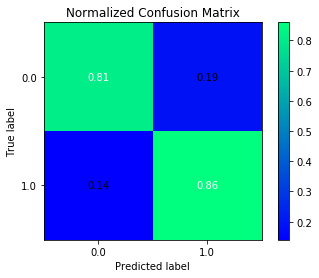

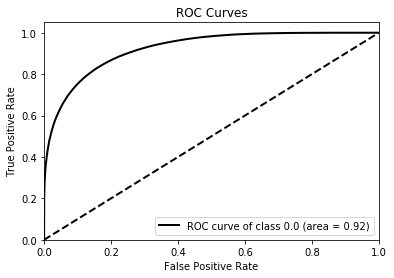

In [36]:
y_pred = model.predict(X_valid)
evaluate_performace(y_valid, y_pred, threshold=0.5)

# Final Prediction

In [0]:
model.fit(x = X_valid,
          y = y_valid,
          batch_size = 5000,
          epochs = 5)

In [0]:
X_test = test_data[vars]

In [41]:
idx = ~X_test.TX_pair.isna()
X_test.loc[~idx, list(set(X_test.columns) - {"TX", "TY", "X", "Y", "Z"})] = np.random.normal(size=(128639, 10))

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
probas = model.predict(X_test, batch_size=5000)

In [0]:
df = pd.DataFrame({'id': test_data["index"], 'signal': probas.reshape(-1)}).groupby('id')
agg = df.aggregate(('mean')).loc[:, ['signal']]

In [0]:
agg.to_csv('submission.csv.gz', index=True, compression='gzip')

In [0]:
del df, agg